<a href="https://colab.research.google.com/github/KaxitPandya/699-Project/blob/main/ECE_699A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing variables from json:
import json
with open('./input copy.json', 'r') as f:
    input_data = json.load(f)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Model Training

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_csv(input_data['dataset_path3'])

X = data.drop("Target", axis=1).values
y = data["Target"].values

# Normalize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Split into training and testing datasets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# 2. Define the Sparse Autoencoder Model in TensorFlow/Keras
r2_score_list=[]
for i in range(5):
    # Split into training and testing datasets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42+i)
    
    input_dim = X_train.shape[1]
    latent_dim = 64  # tune this based on dataset
    
    #input
    input_layer = keras.Input(shape=(input_dim,))
    
    # Encoder
    encoded = layers.Dense(128, activation='relu')(input_layer)
    # Latent representation with L1 activity regularization to encourage sparsity
    latent = layers.Dense(latent_dim, activation='relu',
                          activity_regularizer=regularizers.l1(1e-3))(encoded)
    
    # Decoder
    decoded = layers.Dense(128, activation='relu')(latent)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)  # Use linear activation for reconstruction
    
    # Autoencoder model
    autoencoder = keras.Model(inputs=input_layer, outputs=decoded, name="sparse_autoencoder")
    autoencoder.compile(optimizer='adam', loss='mse')
    
    #autoencoder.summary()
    # Training the autoencoder
    epochs = 200
    batch_size = 8
    
    history = autoencoder.fit(X_train, X_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_split=0.1,verbose=0)
    # 4. Create the Encoder Model for Feature Extraction
    # Create a model to extract the latent features
    encoder = keras.Model(inputs=input_layer, outputs=latent, name="encoder")
    latent_train = encoder.predict(X_train)
    latent_test = encoder.predict(X_test)
    
    
    ###Let's do RF model using latent_train
    from sklearn.ensemble import RandomForestRegressor as RFR
    mymodel  = RFR(random_state=97)
    mymodel.fit(latent_train,y_train)
    y_pred = mymodel.predict(latent_test)
    r2_score_list.append(r2_score(y_test,y_pred))
r2_score_list

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[0.898301521873359,
 0.7895787516453514,
 0.6485015120084294,
 0.9229398849390652,
 0.9292648344842832]

In [6]:
import matplotlib.pyplot as plt 

In [7]:
np.mean(r2_score_list)

np.float64(0.8377173009900976)

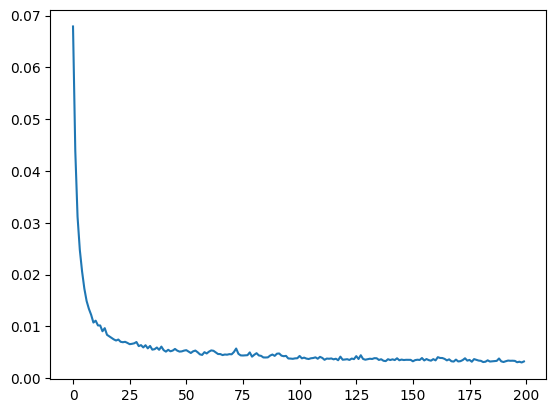

In [8]:
plt.plot(history.history['val_loss'])
plt.show()

In [9]:
from sklearn.metrics import r2_score
print(r2_score(y_test,y_pred))

0.9292648344842832


In [10]:
# 5. Build and Train a Downstream Regression Model for AGB Prediction
r2_score_list=[]
for i in range(5):
    # Split into training and testing datasets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42+i)
    latent_train = encoder.predict(X_train)
    latent_test = encoder.predict(X_test)
    
    reg_input = keras.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(reg_input)
    x = layers.Dense(32, activation='relu')(x)
    # Single output neuron for regression (AGB value)
    reg_output = layers.Dense(1, activation='linear')(x)
    regressor = keras.Model(inputs=reg_input, outputs=reg_output, name="regressor")
    
    regressor.compile(optimizer='adam', loss='mse', metrics=['mae'])
    #regressor.summary()
    
    reg_epochs = 300
    reg_history = regressor.fit(latent_train, y_train,
                                epochs=reg_epochs,
                                batch_size=8,
                                validation_split=0.1,
                                verbose=0)  # Set verbose=1 to see training progress
    y_pred = regressor.predict(latent_test).flatten()
    mse_value = mean_squared_error(y_test, y_pred)
    print(f"Test MSE for AGB prediction: {mse_value:.4f}")
    
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test, y_pred)
    print(f"Test R^2 for AGB prediction: {r2:.4f}")
    r2_score_list.append(r2)
np.mean(r2_score_list)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Test MSE for AGB prediction: 4511.4015
Test R^2 for AGB prediction: 0.9040
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Test MSE for AGB prediction: 3903.0457
Test R^2 for AGB prediction: 0.8422
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Test MSE for AGB prediction: 6294.8189
Test R^2 for AGB prediction: 0.8259
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Test MSE for AGB prediction: 3428.1805
Test R^2 for AGB prediction: 0.9226
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Test MSE for AGB prediction: 3237.2064
Test R^2 for AGB prediction: 0.9279


np.float64(0.8845460856747716)

In [11]:
r2_score_list

[0.90404322832428,
 0.8422287535936099,
 0.8258979776588836,
 0.9226245817681519,
 0.9279358870289325]

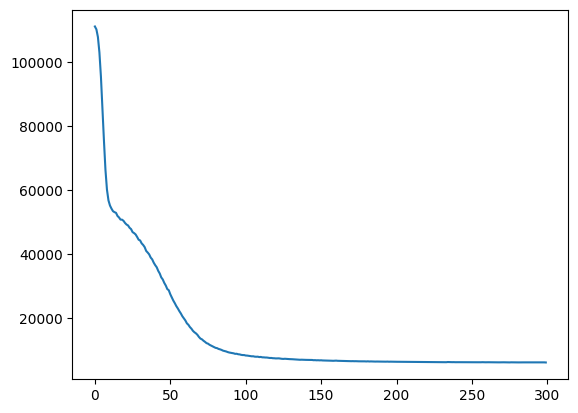

In [12]:
plt.plot(reg_history.history['val_loss'])

In [13]:
# make graphs